Class names: ['bcc', 'mel', 'other', 'scc']


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/905314190.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Using device: cuda
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496


<Figure size 1000x800 with 0 Axes>

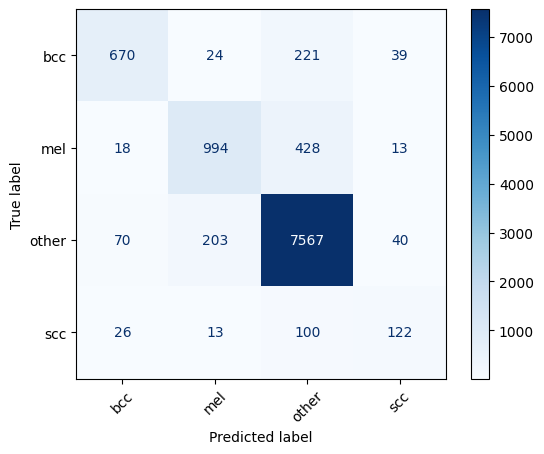


Classification Report:
               precision    recall  f1-score   support

         bcc       0.85      0.70      0.77       954
         mel       0.81      0.68      0.74      1453
       other       0.91      0.96      0.93      7880
         scc       0.57      0.47      0.51       261

    accuracy                           0.89     10548
   macro avg       0.79      0.70      0.74     10548
weighted avg       0.88      0.89      0.88     10548



In [2]:
!pip install torch torchvision transformers datasets scikit-learn
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Ruta al archivo de los pesos del modelo guardados
model_weights_path = '/kaggle/input/model-trained-for-competition/transformer_model_weights.pth'

# Directorio de las imágenes de prueba
test_data_dir = ''

# Definir las transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imágenes a 224x224 píxeles
    transforms.ToTensor(),  # Convertir imágenes a tensores PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar imágenes
])

# Cargar el conjunto de datos de prueba
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extraer los nombres de las clases del conjunto de datos
class_names = test_dataset.classes
print("Class names:", class_names)

# Cargar el modelo preentrenado ViT con el número de clases correcto
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224-in21k', num_labels=len(class_names), ignore_mismatched_sizes=True)

# Cargar los pesos del modelo desde el archivo
model.load_state_dict(torch.load(model_weights_path))

# Comprobar si GPU (CUDA) está disponible, de lo contrario, usar CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

# Establecer el modelo en modo de evaluación
model.eval()

# Función para evaluar el modelo en los datos de prueba y obtener la confusión matriz
def evaluate(model, dataloader, device):
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Desactivar el cálculo de gradientes para la inferencia
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits  # Obtener las predicciones del modelo
            _, predicted = torch.max(outputs, 1)  # Obtener la clase predicha
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Almacenar las etiquetas verdaderas y predichas
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            # Imprimir la etiqueta verdadera y la predicha para cada imagen en el lote
#             for true_label, pred_label in zip(labels, predicted):
#                 print(f"True Label: {class_names[true_label]}, Predicted: {class_names[pred_label]}")

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

# Evaluar el modelo en los datos de prueba
test_accuracy, all_labels, all_preds = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generar la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

# Imprimir el reporte de clasificación
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)